# MPC Evaluation Across Weather Scenarios

This notebook:
1. Loads the same 20 weather scenarios generated by the GA notebook
2. Runs MPC on each scenario (MPC adapts to changing conditions!)
3. Saves results for comparison with GA's fixed strategy

In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys
import time

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.mpc.mpc import MPC
from core.mpc.mpc_params import MPCParams
from core.mpc.mpc_bounds import ControlInputBounds

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities

from core.ga.ga_params import GeneticAlgorithmParams

from core.weather.stochastic_weather import (
    WeatherScenario,
    scenarios_to_dataframe
)

from core.plotting.plotting_params import PlottingParams
from core.plotting.plotting_colors import PlottingColors

# Apply plotting style (LaTeX + color-blind friendly)
plotting_params = PlottingParams()
plotting_colors = PlottingColors()
plotting_colors.apply_as_default()

## 1. Load Weather Scenarios

In [2]:
# Load weather scenarios (generated by ga_weather_scenarios.ipynb)
with open('weather_scenario_results/weather_scenarios.pkl', 'rb') as f:
    weather_data = pickle.load(f)

with open('weather_scenario_results/scenario_configs.pkl', 'rb') as f:
    scenarios = pickle.load(f)

print(f"Loaded {len(weather_data)} weather scenarios")
for name in list(weather_data.keys())[:5]:
    print(f"  {name}")
print("  ...")

Loaded 21 weather scenarios
  normal_1
  normal_2
  normal_3
  normal_4
  normal_5
  ...


In [3]:
# Load GA results for comparison reference
with open('weather_scenario_results/ga_optimal_strategy.pkl', 'rb') as f:
    ga_optimal = pickle.load(f)

print(f"GA optimal strategy: {ga_optimal['strategy']}")
print(f"GA baseline revenue: ${ga_optimal['baseline_revenue']:.2f}")

GA optimal strategy: [2.87195789e+03 2.88841326e-01 3.28009299e+02 4.55561329e+01]
GA baseline revenue: $1024.46


## 2. Model and MPC Parameters

In [4]:
# Set ModelParams (hourly time stepping for MPC)
model_params = ModelParams(
    dt               = 1.0,  # hours/step (MPC uses hourly)
    simulation_hours = 2900, # hours
    closed_form      = False,
    verbose          = False
)

In [5]:
# Set ModelCarryingCapacities (corn defaults)
carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,  # m
    kA = 0.65, # m2
    kN = 20,   # number of leaves
    kc = 1000, # number of spikelets
    kP = 0.25  # kg
)

In [6]:
# Set ModelGrowthRates
growth_rates = ModelGrowthRates(
    ah = 0.01,   # 1/hr
    aA = 0.0105, # 1/hr
    aN = 0.011,  # 1/hr
    ac = 0.01,   # 1/hr
    aP = 0.005   # 1/hr
)

In [7]:
# Set ModelSensitivities
sensitivities = ModelSensitivities(
    sigma_W = 30,  # hrs
    sigma_F = 300, # hrs
    sigma_T = 30,  # hrs
    sigma_R = 30   # hrs
)

In [8]:
# Set ModelInitialConditions
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours,
    A0=carrying_capacities.kA/model_params.simulation_hours,
    N0=carrying_capacities.kN/model_params.simulation_hours,
    c0=carrying_capacities.kc/model_params.simulation_hours,
    P0=carrying_capacities.kP/model_params.simulation_hours
)

In [9]:
# Set typical disturbances
default_typical_disturbances = ModelTypicalDisturbances()

typical_disturbances = ModelTypicalDisturbances(
    typical_water       = default_typical_disturbances.typical_water * model_params.dt,
    typical_fertilizer  = default_typical_disturbances.typical_fertilizer * model_params.dt,
    typical_temperature = default_typical_disturbances.typical_temperature * model_params.dt,
    typical_radiation   = default_typical_disturbances.typical_radiation * model_params.dt
)

In [10]:
# MPC parameters
mpc_params = MPCParams(
    daily_horizon   = 7,  # 7-day lookahead
    solver          = "ipopt",
    solver_options  = {
        "tol": 1e-4,
        "acceptable_iter": 100,
        "max_iter": 500,
        "print_level": 0,  # quiet for batch runs
        "mu_strategy": "adaptive",
        "linear_solver": "mumps",
    }
)

bounds = ControlInputBounds()

In [11]:
# Get economic weights (same as GA for fair comparison)
ga_params = GeneticAlgorithmParams()
weight_fruit_biomass = ga_params.weight_fruit_biomass
weight_height = ga_params.weight_height
weight_leaf_area = ga_params.weight_leaf_area
weight_irrigation = ga_params.weight_irrigation
weight_fertilizer = ga_params.weight_fertilizer

## 3. Run MPC on Each Weather Scenario

Unlike GA's fixed strategy, MPC re-optimizes daily based on observed conditions.

In [12]:
# Run MPC on each weather scenario
mpc_results = {}
mpc_trajectories = {}  # Store full trajectories for detailed analysis

scenario_names = list(weather_data.keys())
total_scenarios = len(scenario_names)

print(f"Running MPC on {total_scenarios} scenarios...")
print("(This may take a while - MPC solves an optimization problem each day)\n")

for i, scenario_name in enumerate(scenario_names):
    print(f"[{i+1}/{total_scenarios}] Running MPC on {scenario_name}...")
    
    weather_df = weather_data[scenario_name]
    
    # Create disturbances for this scenario
    scenario_disturbances = ModelDisturbances(
        precipitation = weather_df['Hourly Precipitation (in)'].to_numpy(),
        radiation     = weather_df['Hourly Radiation (W/m2)'].to_numpy(),
        temperature   = weather_df['Temperature (C)'].to_numpy()
    )
    
    # Create MPC controller
    mpc = MPC(
        carrying_capacities  = carrying_capacities,
        disturbances         = scenario_disturbances,
        growth_rates         = growth_rates,
        initial_conditions   = initial_conditions,
        model_params         = model_params,
        typical_disturbances = typical_disturbances,
        sensitivities        = sensitivities,
        mpc_params           = mpc_params,
        bounds               = bounds
    )
    
    # Run MPC
    t_start = time.time()
    try:
        result = mpc.run()
        t_elapsed = time.time() - t_start
        
        # Calculate revenue
        P_final = result["P"][-1]
        h_final = result["h"][-1]
        A_final = result["A"][-1]
        total_irrigation = np.sum(result["irrigation"])
        total_fertilizer = np.sum(result["fertilizer"])
        
        profit = (weight_fruit_biomass * P_final + 
                  weight_height * h_final + 
                  weight_leaf_area * A_final)
        expenses = (weight_irrigation * total_irrigation + 
                    weight_fertilizer * total_fertilizer)
        revenue = profit - expenses
        
        mpc_results[scenario_name] = {
            'revenue': revenue,
            'profit': profit,
            'expenses': expenses,
            'fruit_biomass': P_final,
            'height': h_final,
            'leaf_area': A_final,
            'total_irrigation': total_irrigation,
            'total_fertilizer': total_fertilizer,
            'runtime_seconds': t_elapsed,
            'precip_total': weather_df['Hourly Precipitation (in)'].sum(),
            'temp_mean': weather_df['Temperature (C)'].mean()
        }
        
        # Store trajectories for detailed analysis
        mpc_trajectories[scenario_name] = result
        
        print(f"    Revenue=${revenue:7.2f}, Fruit={P_final:.3f}kg, Time={t_elapsed:.1f}s")
        
    except Exception as e:
        print(f"    ERROR: {e}")
        mpc_results[scenario_name] = {
            'revenue': np.nan,
            'error': str(e)
        }

print("\nMPC runs complete!")

Running MPC on 21 scenarios...
(This may take a while - MPC solves an optimization problem each day)

[1/21] Running MPC on normal_1...
[Daily MPC] Day 1/120, hour index 0
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 2/120, hour index 24
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 3/120, hour index 48
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 4/120, hour index 72
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 5/120, hour index 96
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 6/120, hour index 120
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 7/120, hour index 144
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 8/120, hour index 168
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 9/120, hour index 192
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 10/120, hour index 216
[CFTOC] Solver status: ok, termination: optimal
[Daily MP

In [13]:
# Convert to DataFrame
mpc_results_df = pd.DataFrame(mpc_results).T
mpc_results_df.index.name = 'scenario'
mpc_results_df = mpc_results_df.reset_index()

# Add extremity index
scenario_configs = {s.name: s for s in scenarios}
mpc_results_df['extremity'] = mpc_results_df['scenario'].apply(
    lambda x: scenario_configs[x].extremity_index() if x in scenario_configs else 0.0
)

print("\nMPC Results Summary:")
print(mpc_results_df[['scenario', 'revenue', 'fruit_biomass', 'total_irrigation', 
                       'total_fertilizer', 'runtime_seconds', 'extremity']].to_string())


MPC Results Summary:
                scenario      revenue  fruit_biomass  total_irrigation  total_fertilizer  runtime_seconds  extremity
0               normal_1   918.718565       0.202278          4.296863        285.164225        19.545639       0.00
1               normal_2   964.008056       0.209890          3.923270        274.678964        20.290981       0.20
2               normal_3   882.030392       0.196179          4.555870        294.119223        24.450406       0.20
3               normal_4  1005.004062       0.216832          3.984553        263.671962        24.225126       0.40
4               normal_5   853.711832       0.191100          4.493588        300.135089        20.717280       0.40
5           moderate_dry   974.115727       0.213266          4.508027        280.985277        19.797054       0.80
6           moderate_wet   774.867212       0.177278          5.326447        320.075672        20.053055       0.70
7          moderate_warm   956.597230     

In [14]:
# Save MPC results
with open('weather_scenario_results/mpc_scenario_results.pkl', 'wb') as f:
    pickle.dump(mpc_results, f)

with open('weather_scenario_results/mpc_trajectories.pkl', 'wb') as f:
    pickle.dump(mpc_trajectories, f)

mpc_results_df.to_csv('weather_scenario_results/mpc_scenario_results.csv', index=False)

print("MPC results saved.")

MPC results saved.


## 4. Summary Statistics

In [15]:
# Summary statistics
valid_results = mpc_results_df[mpc_results_df['revenue'].notna()]

print("MPC Adaptive Strategy Performance Across Scenarios")
print("=" * 50)
print(f"Mean revenue:   ${valid_results['revenue'].mean():.2f}")
print(f"Std revenue:    ${valid_results['revenue'].std():.2f}")
print(f"Min revenue:    ${valid_results['revenue'].min():.2f} ({valid_results.loc[valid_results['revenue'].idxmin(), 'scenario']})")
print(f"Max revenue:    ${valid_results['revenue'].max():.2f} ({valid_results.loc[valid_results['revenue'].idxmax(), 'scenario']})")
print(f"\nBaseline revenue: ${valid_results[valid_results['scenario'] == 'baseline']['revenue'].values[0]:.2f}")
print(f"\nMean runtime: {valid_results['runtime_seconds'].mean():.1f} seconds per scenario")

MPC Adaptive Strategy Performance Across Scenarios
Mean revenue:   $855.29
Std revenue:    $131.90
Min revenue:    $522.91 (worst_case)
Max revenue:    $1005.00 (normal_4)

Baseline revenue: $916.47

Mean runtime: 22.0 seconds per scenario


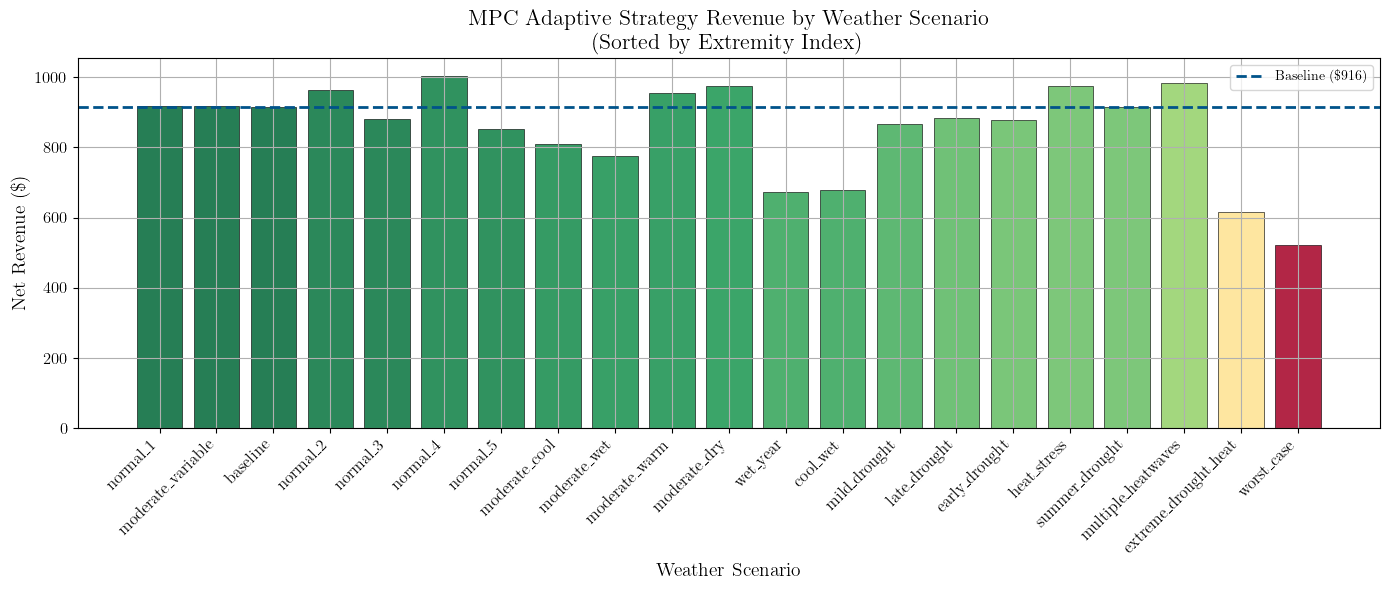

In [16]:
# Plot revenue by scenario
fig, ax = plt.subplots(figsize=(14, 6))

# Sort by extremity
df_sorted = valid_results.sort_values('extremity')

# Create color gradient based on extremity
max_extremity = df_sorted['extremity'].max()
if max_extremity > 0:
    colors = plt.cm.RdYlGn_r(df_sorted['extremity'] / max_extremity)
else:
    colors = [plotting_colors.vivid_green] * len(df_sorted)

bars = ax.bar(range(len(df_sorted)), df_sorted['revenue'], color=colors,
              alpha=0.85, edgecolor='black', linewidth=0.5)
ax.set_xticks(range(len(df_sorted)))
ax.set_xticklabels(df_sorted['scenario'], rotation=45, ha='right')
ax.set_xlabel('Weather Scenario')
ax.set_ylabel('Net Revenue (\\$)')
ax.set_title('MPC Adaptive Strategy Revenue by Weather Scenario\n(Sorted by Extremity Index)')

# Get baseline revenue
baseline_rows = valid_results[valid_results['scenario'] == 'baseline']
if len(baseline_rows) > 0:
    baseline_revenue = baseline_rows['revenue'].values[0]
    ax.axhline(baseline_revenue, color=plotting_colors.strong_blue, 
               linestyle='--', linewidth=2, label=f'Baseline (\\${baseline_revenue:.0f})')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('weather_scenario_results/mpc_revenue_by_scenario.png', dpi=150, bbox_inches='tight')
plt.show()

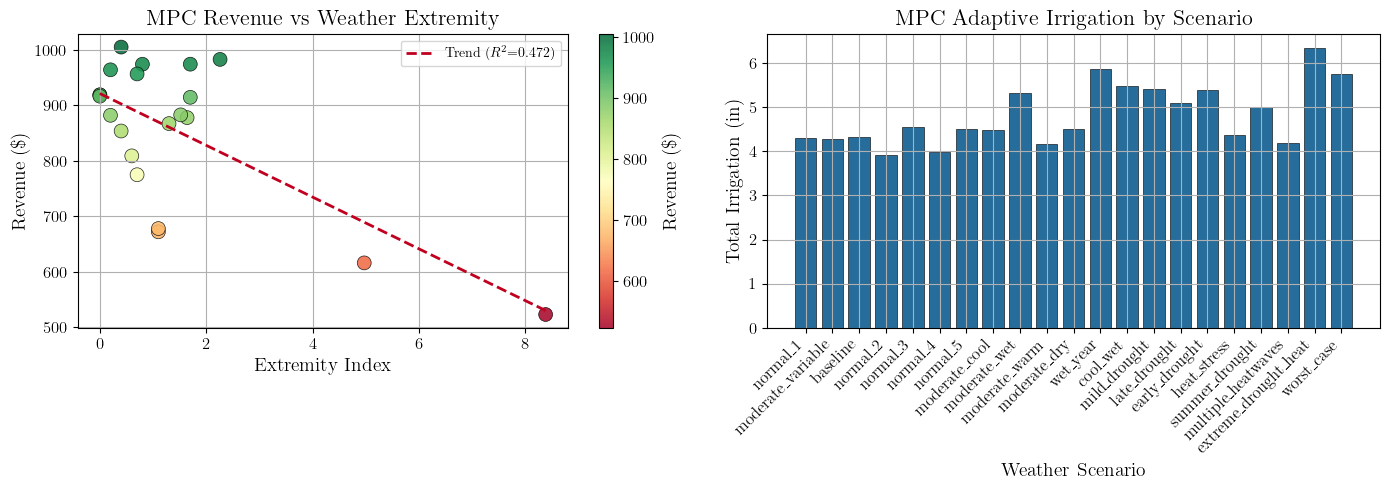


MPC Revenue vs Extremity Correlation:
  Pearson R = -0.687
  Slope = \$-46.68 per unit extremity


In [17]:
# Plot revenue vs extremity with trend line
from scipy import stats

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Revenue vs Extremity scatter
ax1 = axes[0]
sc = ax1.scatter(valid_results['extremity'], valid_results['revenue'], 
                 c=valid_results['revenue'], cmap='RdYlGn', s=100,
                 edgecolor='black', linewidth=0.5, alpha=0.85)
plt.colorbar(sc, ax=ax1, label='Revenue (\\$)')

# Add trend line
slope, intercept, r_value, p_value, _ = stats.linregress(
    valid_results['extremity'], valid_results['revenue'])
x_trend = np.linspace(0, valid_results['extremity'].max(), 100)
ax1.plot(x_trend, slope * x_trend + intercept, color=plotting_colors.vivid_red,
         linestyle='--', linewidth=2, label=f'Trend ($R^2$={r_value**2:.3f})')

ax1.set_xlabel('Extremity Index')
ax1.set_ylabel('Revenue (\\$)')
ax1.set_title('MPC Revenue vs Weather Extremity')
ax1.legend(loc='upper right')

# Right: Resource usage (irrigation) by scenario
ax2 = axes[1]
df_sorted = valid_results.sort_values('extremity')
ax2.bar(range(len(df_sorted)), df_sorted['total_irrigation'], 
        color=plotting_colors.strong_blue, alpha=0.85, edgecolor='black', linewidth=0.5)
ax2.set_xticks(range(len(df_sorted)))
ax2.set_xticklabels(df_sorted['scenario'], rotation=45, ha='right')
ax2.set_xlabel('Weather Scenario')
ax2.set_ylabel('Total Irrigation (in)')
ax2.set_title('MPC Adaptive Irrigation by Scenario')

plt.tight_layout()
plt.savefig('weather_scenario_results/mpc_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nMPC Revenue vs Extremity Correlation:")
print(f"  Pearson R = {r_value:.3f}")
print(f"  Slope = \\${slope:.2f} per unit extremity")